Showing how to do the contour, box, and line plots from "Density dependence and a colonization rule predict spatial patterning". This is Figs. 2, 3 for the BCI data. The data itself is available from Dryad at https://doi.org/10.15146/5xcp-0d46.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
from scipy.optimize import minimize_scalar
import dd_functions as dd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

In [2]:
# Read in data
b_loc = 'Location_Of_bci5.txt' # Or whatever BCI data you want to use.
bci = pd.read_csv(b_loc,sep='\t')
# Trim to only alive species with dbh > 10
bciA = bci.loc[(bci['dbh']>=100)&(bci['status']=='A')]
# Get unique species identifiers
spl = bciA['sp'].unique()
# Get total number
s0 = bciA.sp.nunique() # or len(spl), just showing different syntax
# Get total number of individuals
n0 = len(bciA)

In [3]:
# Create bisection and fraction data for 10 cm dbh
b10 = dd.bisect(bciA,1000,500,level=1)
f10 = dd.create_f(b10,thresh=0)

# Aggregate $\alpha$

In [4]:
# Get bestfit alpha
al10 = minimize_scalar(dd.loglikelihood,bounds=(0.8,1.5),method='bounded',
                args=(np.rint(f10['frac']*f10['n0']).astype(int),f10['n0']))

In [5]:
al10

     fun: 659.837902607894
 message: 'Solution found.'
    nfev: 12
  status: 0
 success: True
       x: 1.1224099629374666

In [6]:
# Compare to other models and make sure it's working:
# Density dependent
print(dd.loglikelihood(al10.x,np.rint(f10['frac']*f10['n0']).astype(int),f10['n0']))
# METE
print(-np.sum(np.log(1/(f10['n0']+1))))
# RP
print(-np.sum(st.binom.logpmf(np.rint(f10['frac']*f10['n0']).astype(int),f10['n0'], 0.5)))
# Can get deviance as |mete-density dependent|*2, then use this as the argument for a chi^2 distribution
# with one extra parameter (k=1). Then 1-CDF gives a p-value.
print("p-value: {}".format(
  1-st.chi2.cdf(2*(-np.sum(np.log(1/(f10['n0']+1)))-dd.loglikelihood(
      al10.x,np.rint(f10['frac']*f10['n0']).astype(int),f10['n0'])),1)))

659.837902607894
728.7097286584718
963.0670787863642
p-value: 0.0


## Contours

In [7]:
# Get 95% contour information
pc = 0.05 # 95 percent contour

abund10 = bciA['sp'].value_counts()
nmax = abund10[0]
logrange,dda_int = dd.contours(al10.x,pc,nmax)
# Set up arrays
bi_int = []
mete_int = []
for n in logrange: # Use max from c_trim, but sample logarithmically
    # Binomial
    bi_int_t = st.binom.interval(1-pc,n,0.5)
    bi_int.append((bi_int_t[0]/n,bi_int_t[1]/n))
    # METE
    mete_int.append((np.floor(pc/2*(n+1))/(n+1),np.ceil((1-pc/2)*(n+1))/(n+1)))

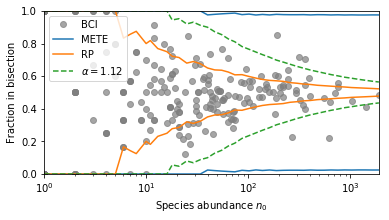

In [8]:
# Now plot these contour intervals
fig,ax = plt.subplots(figsize=(6,3))
colors = plt.get_cmap("tab10")
# Plot with abundance on x instead of rank ordering
bcip = ax.semilogx(abund10.sort_index(),f10['frac'],'o',c=colors(7),alpha=0.7,label='BCI')
metep = ax.semilogx(logrange,mete_int,c=colors(0),label='METE')
bip = ax.semilogx(logrange,bi_int,c=colors(1),label='RP')
alp = ax.semilogx(logrange,dda_int,'--',c=colors(2),label=r'$\alpha={:.2f}$'.format(al10.x))
ax.legend((bcip[0],metep[0],bip[0],alp[0]),('BCI','METE','RP',r'$\alpha={:.2f}$'.format(al10.x)))
ax.set_ylim(0,1)
ax.set_xlim(1,nmax)
ax.set_ylabel('Fraction in bisection')
ax.set_xlabel(r'Species abundance $n_0$')
fig_name = 'FigureFilename.pdf'
plt.savefig(fig_name,format='pdf',bbox_inches='tight')

# Individual species at different scales

In [9]:
# Create fractions for eaach species
# Keep threshold at 128 everywhere
th = 128
# 8 Bisections
bi8 = dd.bisect(bciA,1000,500,level=8)
fr8 = dd.create_f(bi8,thresh=128)
# 7 Bisections
bi7 = dd.bisect(bciA,1000,500,level=7)
fr7 = dd.create_f(bi7,thresh=128)
# 6 Bisections
bi6 = dd.bisect(bciA,1000,500,level=6)
fr6 = dd.create_f(bi6,thresh=128)
# 5 Bisections
bi5 = dd.bisect(bciA,1000,500,level=5)
fr5 = dd.create_f(bi5,thresh=128)
# 4 Bisections
bi4 = dd.bisect(bciA,1000,500,level=4)
fr4 = dd.create_f(bi4,thresh=128)
# 3 Bisections
bi3 = dd.bisect(bciA,1000,500,level=3)
fr3 = dd.create_f(bi3,thresh=128)
# 2 Bisections with appropriate threshold
bi2 = dd.bisect(bciA,1000,500,level=2)
fr2 = dd.create_f(bi2,thresh=128)

In [10]:
# For every species, get alpha at each scale, then save to an array.
# Create species list of abundance > 128
spla = fr2['sp'].unique()
sp_al = np.zeros([len(spla),6]) # six is the number of scales
for i,sp in enumerate(spla):
    al8 = minimize_scalar(dd.loglikelihood,bounds=(0.1,4),method='bounded',
                    args=(np.rint(fr8[fr8['sp']==sp]['frac']*fr8[fr8['sp']==sp]['n0']).astype(int),
                          fr8[fr8['sp']==sp]['n0']))
    al7 = minimize_scalar(dd.loglikelihood,bounds=(0.1,4.),method='bounded',
                    args=(np.rint(fr7[fr7['sp']==sp]['frac']*fr7[fr7['sp']==sp]['n0']).astype(int),
                          fr7[fr7['sp']==sp]['n0']))
    al6 = minimize_scalar(dd.loglikelihood,bounds=(0.1,4.),method='bounded',
                    args=(np.rint(fr6[fr6['sp']==sp]['frac']*fr6[fr6['sp']==sp]['n0']).astype(int),
                          fr6[fr6['sp']==sp]['n0']))
    al5 = minimize_scalar(dd.loglikelihood,bounds=(0.1,4.),method='bounded',
                    args=(np.rint(fr5[fr5['sp']==sp]['frac']*fr5[fr5['sp']==sp]['n0']).astype(int),
                          fr5[fr5['sp']==sp]['n0']))
    al4 = minimize_scalar(dd.loglikelihood,bounds=(0.1,4.),method='bounded',
                    args=(np.rint(fr4[fr4['sp']==sp]['frac']*fr4[fr4['sp']==sp]['n0']).astype(int),
                          fr4[fr4['sp']==sp]['n0']))
    al3 = minimize_scalar(dd.loglikelihood,bounds=(0.1,4.),method='bounded',
                    args=(np.rint(fr3[fr3['sp']==sp]['frac']*fr3[fr3['sp']==sp]['n0']).astype(int),
                          fr3[fr3['sp']==sp]['n0']))
    al2 = minimize_scalar(dd.loglikelihood,bounds=(0.1,4.),method='bounded',
                    args=(np.rint(fr2[fr2['sp']==sp]['frac']*fr2[fr2['sp']==sp]['n0']).astype(int),
                          fr2[fr2['sp']==sp]['n0']))
    sp_al[i,:] = [al3.x,al4.x,al5.x,al6.x,al7.x,al8.x]

In [11]:
# Make a dataframe with these results
frac_a =[1/2**n for n in np.arange(3,9)] 
df_c = pd.DataFrame(sp_al,index=spla,columns = np.log2(frac_a))

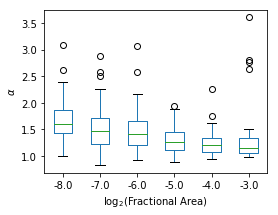

In [12]:
# Boxplots
fig,ax=plt.subplots(figsize=(4,3))
df_c.iloc[:, ::-1].plot(ax=ax,kind='box')
ax.set_ylabel(r'$\alpha$')
ax.set_xlabel(r'$\log_2$(Fractional Area)')
fig_name2 = 'FigureFilename.pdf'
plt.savefig(fig_name2,format='pdf',bbox_inches='tight')
plt.show()

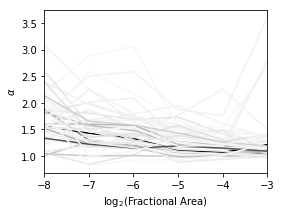

In [13]:
# Plot them all as lines:
fig,ax=plt.subplots(figsize=(4,3))
colors = cm.get_cmap('Greys')
for sp in spla:
    df_c.loc[sp].T.plot(ax=ax,c=colors(abund10[sp]/nmax),label=sp)
# if you want a legend, uncomment.
#ax.legend(ncol=2)
ax.set_xlabel(r'$\log_2$(Fractional Area)')
ax.set_ylabel(r'$\alpha$')
fig_name3 = 'FigureFilename.pdf'
plt.savefig(fig_name3,format='pdf',bbox_inches='tight')
plt.show()